# Data Integrating
* Author: 고지형, [iloveslowfood](https://github.com/iloveslowfood)
* 크롤링한 데이터를 병합한다.


In [2]:
import os
from glob import glob

import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt

In [17]:
path = '../../data/raw/#1. SmartCrawler_MetaTrendData/*'

path_list = glob(path)[1:]
temp = pd.Series(path_list).apply(lambda x: x.split('.csv')[0].split('\\')[-1])

trend = temp[temp.str.endswith('trend')].sort_values(ignore_index=True)
meta = temp[temp.str.endswith('meta')].sort_values(ignore_index=True)

unique_meta = set(meta.apply(lambda x: x.split('_meta')[0]))
unique_trend = set(trend.apply(lambda x: x.split('_trend')[0]))

well_defined = list(unique_meta.intersection(unique_trend))
len(well_defined)

1377

In [74]:
integrated = pd.DataFrame()
type_ = dict(trend='_trend.csv', meta='_meta.csv')
temp = pd.Series(path_list).apply(lambda x: x.split('#1. SmartCrawler_MetaTrendData\\')[-1]).tolist()
origin = '../../data/raw/#1. SmartCrawler_MetaTrendData/'

for idx in range(len(well_defined)):
    if (well_defined[idx] + type_['trend'] in temp) and (well_defined[idx] + type_['meta'] in temp):
        meta = pd.read_csv(os.path.join(origin, well_defined[idx] + type_['meta']))
        trend = pd.read_csv(os.path.join(origin, well_defined[idx] + type_['trend']))
        if meta.shape[0] == 0 or trend.shape[0] == 0:
            continue
        meta = meta.sort_values(by='date', ignore_index=True).drop('thumbnail', axis=1)
        meta.rename({'view': 'video_n_view', 'subscribe':'current_cumul_subs', 
                     'total_cumul_view':'current_cumul_view', 'comment':'n_comment',
                    'like': 'n_like', 'dislike':'n_dislike'}, axis=1, inplace=True)
        trend.rename({'view': 'daily_n_view', 'subscriber': 'cumul_subs'}, axis=1, inplace=True)

        result = trend.merge(meta, how='left', on='date')
        # 결측값 채울 수 있는 정보는 채움 & 기본 정보 추가
        result['current_cumul_view'] = meta['current_cumul_view'][0] # 누적 총 조회수
        result['current_cumul_subs'] = meta['current_cumul_subs'][0]
        result['sign_in'] = meta['sign_in'][0] # 가입일
        result['sign_in'] = result['sign_in'].apply(lambda x: x.replace('.', '-')[:-1])
        result['current_n_video'] = meta.shape[0] # 누적 업로드 영상 수
        result['channel'] = meta['channel'][0]

        col_order = ['channel', 'sign_in', 'date', 'title', 'genre', 'duration', 'video_n_view', 'description', 'n_comment',
         'n_like', 'n_dislike', 'daily_n_view', 'cumul_view', 'cumul_subs', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
        result = result[col_order]
        integrated = pd.concat([integrated, result], ignore_index=True, axis=0)

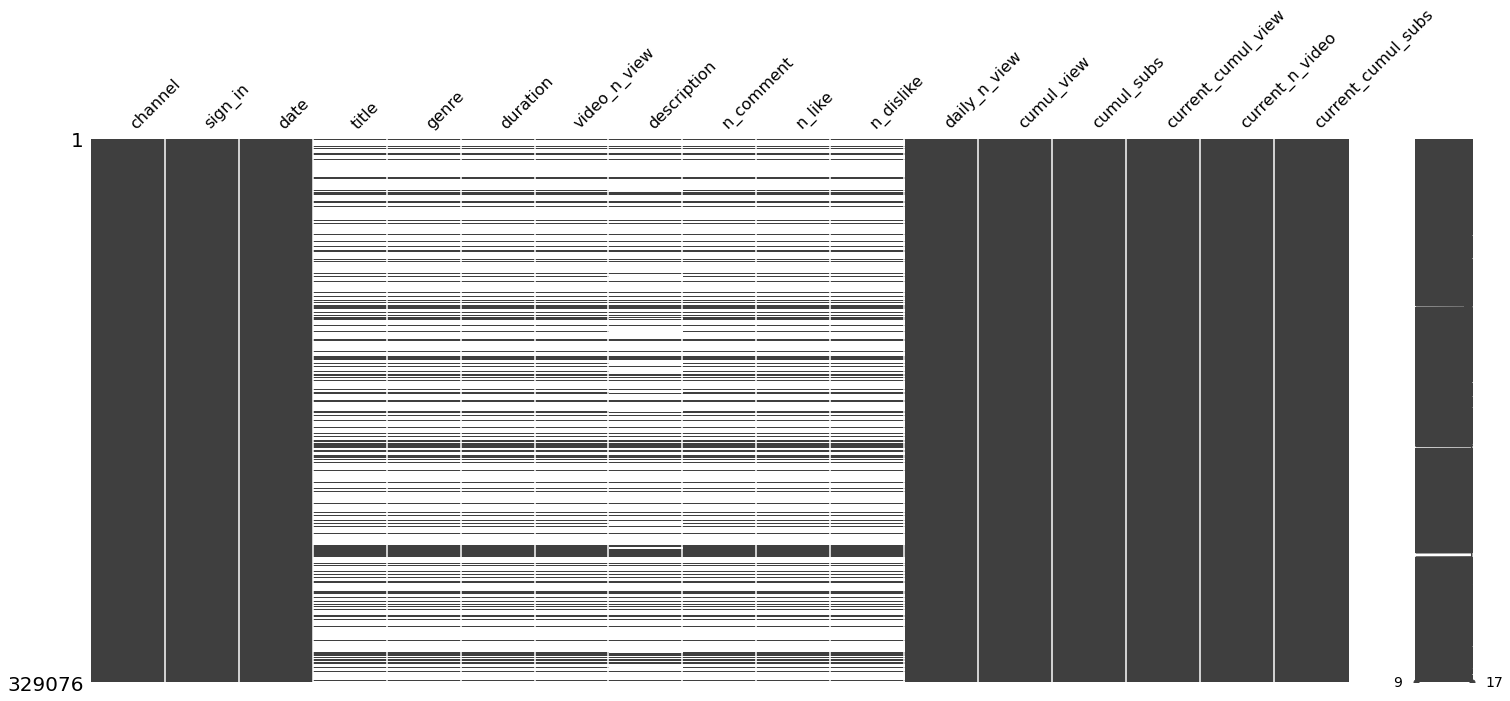

In [75]:
msno.matrix(integrated)
plt.show()

## Save

In [76]:
integrated.to_csv('train_raw(201130).csv', index=False)